# Importación de librerías

A continuación se importan todas las librerías necesarias para cargar las imágenes y construir el modelo de convolución.


In [11]:
# Instalación de Kaggle
!pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [12]:
# Importar librerías

import PIL
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

%matplotlib inline

# Configuración de Kaggle

Se optó por cargar las imágenes utilizando el API de Kaggle por sencillez y eficiencia. La base de datos elegida para entrenar al modelo de convolución contiene imágenes sobre 4 tipos de muestras de sangre. Se eligió esta base de datos ya que modelos de clasificación como el presentado en esta actividad tienen importantes aplicaciones en el sector médico para detectar enfermedades en los pacientes.

En total, este dataset contiene 12,500 imágenes de muestras de sangre con su respectiva etiqueta indicando el tipo de célula detectada. Los tipos de células detectadas se enlistan a continuación:
- Eosinófilos
- Linfocitos
- Monocitos
- Neutrófilos

In [3]:
# Subir llave de Kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elisasnchezbahnsen","key":"f97ef8f184dda833e6876cdb2106e7d2"}'}

In [4]:
# Configuración de la librería de Kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

!chmod 600 ~/.kaggle/kaggle.json # Cambio en los permisos de lectura y escritura

!kaggle datasets list

ref                                                            title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                DAIGT V2 Train Dataset                              29MB  2023-11-16 01:38:36            888        104  1.0              
carlmcbrideellis/llm-7-prompt-training-dataset                 LLM: 7 prompt training dataset                      41MB  2023-11-15 07:32:56           1320        104  1.0              
thedrcat/daigt-proper-train-dataset                            DAIGT Proper Train Dataset                         119MB  2023-11-05 14:03:25           1287        121  1.0              
muhammadbinimran/housing-price-prediction-data                 Housing

In [5]:
# Se descarga la base de datos
!kaggle datasets download -d paultimothymooney/blood-cells

100% 108M/108M [00:06<00:00, 23.9MB/s]
100% 108M/108M [00:06<00:00, 18.6MB/s]


In [6]:
# Se descomprime la carpeta con la imagenes
!unzip blood-cells.zip -d "/content/kaggledb" # esto se verá en la carpeta de content > kaggledb

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: /c

# Preparación de los datos
Una vez cargadas las imágenes al entorno de ejecución, estas se mezclan de forma aleatoria en batches de 128 imágenes cada uno. En la siguiente celda se aprecia el tamaño del set de entrenamiento validación y prueba.

In [ ]:
# Cargar los datos desde Drive
# Se cargan los datos sin definir un tamaño de entrada

train_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/IDM/School projects/7mo semestre Blumenkron /Blood Cell Images",
  validation_split=0.2, # se cargan los datos con eñ 20% para validación y pruebas
  subset="training",
  seed=123,
  batch_size=128)

val_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/IDM/School projects/7mo semestre Blumenkron /Blood Cell Images",
  validation_split=0.2,
  subset="validation",
  seed=123,
  batch_size=128)

val_size = tf.data.experimental.cardinality(val_ds).numpy()
test_size = int(0.5 * val_size) # Con este 0.5, se usa la mitad del conjunto de validación para pruebas, de esta manera cada uno de estos conjuntos tiene el 10% de los datos

test_ds = val_ds.take(test_size)
val_ds = val_ds.skip(test_size)

In [ ]:
print("Cantidad de batches en training set: ", tf.data.experimental.cardinality(train_ds).numpy())
print("Cantidad de batches en validation set: ", tf.data.experimental.cardinality(val_ds).numpy())
print("Cantidad de batches en test set: ", tf.data.experimental.cardinality(test_ds).numpy())

Cantidad de batches en training set:  34
Cantidad de batches en validation set:  5
Cantidad de batches en test set:  4


In [13]:
# Cargar los datos desde Kaggle (aquí no se usa la división 80-10-10)
# Se crean los batches de entrenamiento,validación y test con las cuatro clases de forma aleatoria
# Se cargan los datos sin definir un tamaño de entrada

%cd "/content/kaggledb/dataset2-master/dataset2-master/images/"

train_dataset = image_dataset_from_directory(
    pathlib.Path("TRAIN"),
    batch_size=128,
    shuffle=True,
    crop_to_aspect_ratio= True)
validation_dataset = image_dataset_from_directory(
    pathlib.Path("TEST"),
    batch_size=128,
    shuffle=True,
    crop_to_aspect_ratio= True)
test_dataset = image_dataset_from_directory(
    pathlib.Path("TEST_SIMPLE"),
    batch_size=128,
    shuffle=True,
    crop_to_aspect_ratio= True)


/content/kaggledb/dataset2-master/dataset2-master/images
Found 9957 files belonging to 4 classes.
Found 2487 files belonging to 4 classes.
Found 71 files belonging to 4 classes.


De igual manera y como forma de ejemplo, se imprimen las dimensiones de las imágenes dentro del primer batch

In [14]:
# Se imprime el tamaño de las imágenes dentro de los batches
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  print(labels_batch)
  break

data batch shape: (128, 256, 256, 3)
labels batch shape: (128,)
tf.Tensor(
[2 3 2 2 3 3 2 3 1 0 1 1 0 3 2 3 1 0 3 0 2 1 1 1 0 1 0 0 3 1 1 0 1 1 1 3 1
 1 2 2 2 1 1 1 3 3 2 2 2 1 2 2 0 1 1 2 2 1 3 0 3 3 1 1 2 2 0 2 2 0 1 2 0 2
 3 1 2 3 2 0 2 2 2 2 1 2 3 2 3 2 3 0 3 1 1 0 1 3 3 1 1 2 2 3 3 2 0 3 1 2 0
 1 0 3 1 3 2 2 2 1 0 1 1 1 3 1 1 3], shape=(128,), dtype=int32)


# Entrega 1

## Modelo 1
Ya con una mejor comprensión de los datos y con una carga exitosa de los mismos, se comienza con la implementación de una red neuronal profunda sencilla. Esta contiene tres capas de convolución con kernel de tamaño 3x3 y función de activación ReLu. Estas capas convolutivas están intercaladas con algunas capas de Max Pooling. La red termina con dos capas densas, siendo una de ellas la capa de salida con función de activación Softmax para la clasificación.

Además, en la compilación se utiliza una función de pérdida "sparse_categorical_crossentropy" y un optimizador "Adam".

In [ ]:
# Se establece el tamaño inicial que necesitamos y la cantidad de categorías a clasificar
input_shape = (240, 320, 3)
num_classes = 4

# Construcción de un modelo secuencial
model = Sequential()
model.add(Rescaling(scale=1./255, input_shape=input_shape))

# Capas convolucionales iniciales
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa para "aplanar" las imágenes antes de las capas densas
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Se muestra la arquitectura completa del modelo. En total se tienen que entrenar 69,826,116 parámetros.

In [ ]:
# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 320, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 238, 318, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 119, 159, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 157, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 58, 78, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 76, 128)       7

In [ ]:
# Fit
history = model.fit(train_dataset, validation_data=validation_dataset, batch_size=64, epochs=20)

Epoch 1/20
78/78 [==============================] - 41s 396ms/step - loss: 2.0092 - accuracy: 0.2490 - val_loss: 1.3863 - val_accuracy: 0.2509
Epoch 2/20
78/78 [==============================] - 27s 334ms/step - loss: 1.3864 - accuracy: 0.2455 - val_loss: 1.3863 - val_accuracy: 0.2509
Epoch 3/20
78/78 [==============================] - 27s 334ms/step - loss: 1.3864 - accuracy: 0.2456 - val_loss: 1.3863 - val_accuracy: 0.2509
Epoch 4/20
78/78 [==============================] - 28s 348ms/step - loss: 1.3864 - accuracy: 0.2508 - val_loss: 1.3865 - val_accuracy: 0.2525
Epoch 5/20
78/78 [==============================] - 27s 336ms/step - loss: 1.3866 - accuracy: 0.2497 - val_loss: 1.3863 - val_accuracy: 0.2529
Epoch 6/20
78/78 [==============================] - 27s 333ms/step - loss: 1.3858 - accuracy: 0.2524 - val_loss: 1.3893 - val_accuracy: 0.2453
Epoch 7/20
78/78 [==============================] - 27s 338ms/step - loss: 1.3850 - accuracy: 0.2605 - val_loss: 1.3889 - val_accuracy: 0.2421

In [ ]:
# Convertir resultados a df
df = pd.DataFrame(history.history)
df

,loss,accuracy,val_loss,val_accuracy
0,2.009225,0.248971,1.386298,0.250905
1,1.386379,0.245455,1.386290,0.250905
2,1.386406,0.245556,1.386292,0.250905
3,1.386369,0.250778,1.386505,0.252513
4,1.386636,0.249674,1.386330,0.252915
5,1.385826,0.252385,1.389298,0.245275
6,1.385032,0.260520,1.388888,0.242059
7,1.383495,0.263634,1.388732,0.240048
8,1.381863,0.270061,1.387994,0.258142
9,1.378851,0.275886,1.387524,0.246482


<Axes: title={'center': 'sparse_categorical_accuracy vs Epoch'}>

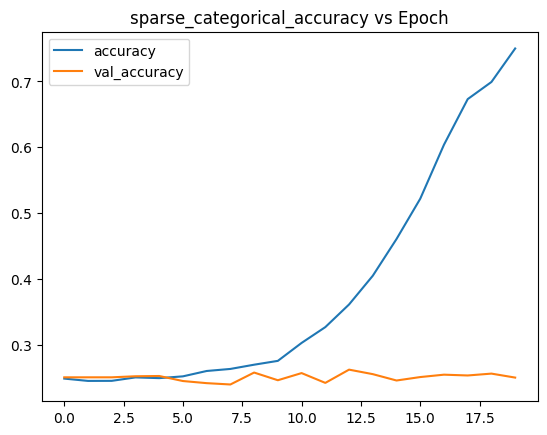

In [ ]:
# Gráfica de accuracy
df.plot(y=["accuracy", "val_accuracy"], title="sparse_categorical_accuracy vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

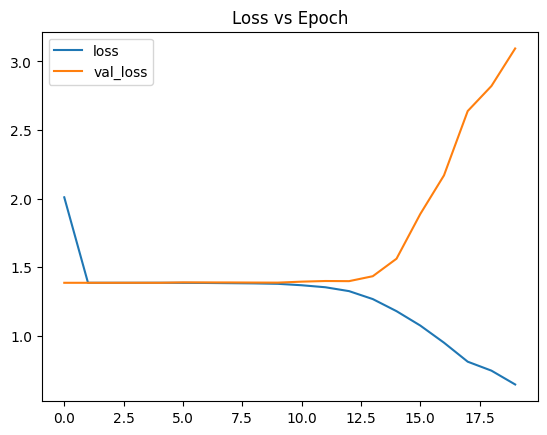

In [ ]:
# Gráfica de pérdida
df.plot(y=["loss", "val_loss"], title="Loss vs Epoch")

Los resultados del entrenamiento de este modelo demuestran un muy mal comportamiento y capacidad de aprender de las imágenes brindadas. Principalmente la gráfica del accuracy muestra un sobre aprendizaje ya que mientras el accuracy del set de prueba continua aumentando, el del set de validación se mantiene constante en 0.25 desde aproximádamente la época 10.

## Modelo 2 (mejorado)

Para mejorar los resultados del modelo anterior, se opta por agregarle técnicas de regularizacion como los dropout con tasa del 0.5 en las últimas capas (FCL). Adicionalmente se modificó la cantidad de neuronas en cada capa convolucional al igual que se agregó una nueva FCL al final.

In [ ]:
# Se establece el tamaño inicial que necesitamos y la cantidad de categorías a clasificar
input_shape = (240, 320, 3)
num_classes = 4

# Construcción de un modelo secuencial
model2 = Sequential()
model2.add(Rescaling(scale=1./255, input_shape=input_shape))
#model2.add(tf.keras.layers.experimental.preprocessing.Resizing(100, 100, interpolation='bilinear'))

# Capas convolucionales iniciales
model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Capa para "aplanar" las imágenes antes de las capas densas
model2.add(Flatten())

# Fully connected layers
model2.add(Dense(512, activation='relu'))

model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Como se esperaba, dada la agregada complejidad del modelo, ahora se tiene una mayor cantidad de parámetros a entrenar: 139,964,292

In [ ]:
# Resumen del modelo
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 320, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 238, 318, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 119, 159, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 157, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 58, 78, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 76, 256)       2

In [ ]:
# Fit
#lr_scheduler = LearningRateScheduler(lr_schedule)
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history2 = model2.fit(train_dataset, validation_data=validation_dataset, batch_size=128, epochs=20)

Epoch 1/20
78/78 [==============================] - 80s 773ms/step - loss: 1.5820 - accuracy: 0.2516 - val_loss: 1.3864 - val_accuracy: 0.2505
Epoch 2/20
78/78 [==============================] - 52s 665ms/step - loss: 1.3866 - accuracy: 0.2482 - val_loss: 1.3863 - val_accuracy: 0.2509
Epoch 3/20
78/78 [==============================] - 53s 676ms/step - loss: 1.3865 - accuracy: 0.2511 - val_loss: 1.3863 - val_accuracy: 0.2509
Epoch 4/20
78/78 [==============================] - 53s 666ms/step - loss: 1.3865 - accuracy: 0.2430 - val_loss: 1.3863 - val_accuracy: 0.2509
Epoch 5/20
78/78 [==============================] - 53s 675ms/step - loss: 1.3864 - accuracy: 0.2458 - val_loss: 1.3863 - val_accuracy: 0.2505
Epoch 6/20
78/78 [==============================] - 53s 666ms/step - loss: 1.3863 - accuracy: 0.2528 - val_loss: 1.3863 - val_accuracy: 0.2509
Epoch 7/20
78/78 [==============================] - 54s 680ms/step - loss: 1.3864 - accuracy: 0.2435 - val_loss: 1.3863 - val_accuracy: 0.2509

KeyboardInterrupt: ignored

In [ ]:
# Convertir resultados a df
df2 = pd.DataFrame(history2.history)
df2

,loss,accuracy,val_loss,val_accuracy
0,1.474498,0.244752,1.386230,0.253317
1,1.385720,0.258612,1.386560,0.250905
2,1.383285,0.272673,1.390826,0.248090
3,1.378958,0.286331,1.395824,0.246482
4,1.371668,0.301999,1.397066,0.262163
5,1.343331,0.338254,1.343583,0.353840
6,1.124262,0.490107,1.117245,0.480499
7,0.951647,0.582103,1.063035,0.515481
8,0.830270,0.648388,1.019424,0.544029
9,0.738987,0.695591,0.976792,0.548050


<Axes: title={'center': 'sparse_categorical_accuracy vs Epoch'}>

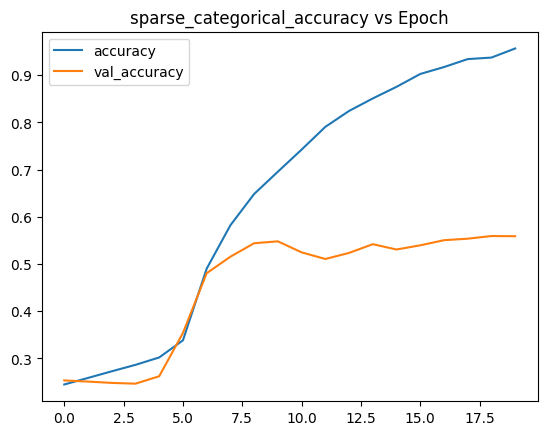

In [ ]:
# Gráfica de accuracy
df2.plot(y=["accuracy", "val_accuracy"], title="sparse_categorical_accuracy vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

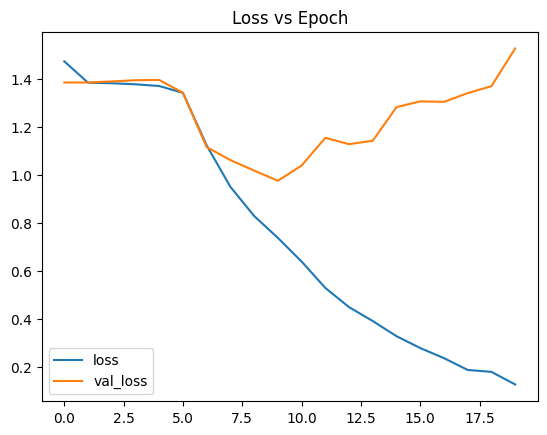

In [ ]:
# Gráfica de pérdida
df2.plot(y=["loss", "val_loss"], title="Loss vs Epoch")

Aunque se sigue percibiendo un gran sobre aprendizaje, también se pudieron apreciar algunas mejoras con este segundo modelo. Principalmente, el accuracy del set de validación aumentó a aproximádamente 0.55 y el de prueba a 0.9.

# Pruebas intermedias

## Modelo 4

**Adiciones / Modificaciones:**

- Se introduce Autotune para mejorar el rendimiento del modelo
- Se agregan capas de Batch Normalization para reducir el overfitting

In [ ]:
# Se establece el tamaño inicial que necesitamos y la cantidad de categorías a clasificar
input_shape = (240, 320, 3)
num_classes = 4

# Construcción de un modelo secuencial
model4 = Sequential()
model4.add(Rescaling(scale=1./255, input_shape=input_shape))
#model2.add(tf.keras.layers.experimental.preprocessing.Resizing(100, 100, interpolation='bilinear'))

# Capas convolucionales iniciales
model4.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))

# Capa para "aplanar" las imágenes antes de las capas densas
model4.add(Flatten())

# Fully connected layers
model4.add(Dense(512, activation='relu'))

model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.5))

model4.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Resumen del modelo
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 320, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 238, 318, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 238, 318, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 119, 159, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 157, 128)     73856     
                                                                 
 batch_normalization_1 (Bat  (None, 117, 157, 128)     5

In [ ]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# Fit
#lr_scheduler = LearningRateScheduler(lr_schedule)
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history4 = model4.fit(train_dataset, validation_data=val_dataset, batch_size=128, epochs=20)

Epoch 1/20
78/78 [==============================] - 113s 1s/step - loss: 8.0440 - accuracy: 0.3024 - val_loss: 20.8286 - val_accuracy: 0.2477
Epoch 2/20
78/78 [==============================] - 82s 1s/step - loss: 1.3406 - accuracy: 0.3047 - val_loss: 5.1627 - val_accuracy: 0.2827
Epoch 3/20
78/78 [==============================] - 88s 1s/step - loss: 1.2473 - accuracy: 0.3666 - val_loss: 3.5665 - val_accuracy: 0.2618
Epoch 4/20
78/78 [==============================] - 83s 1s/step - loss: 1.1324 - accuracy: 0.4475 - val_loss: 1.7236 - val_accuracy: 0.3128
Epoch 5/20
78/78 [==============================] - 82s 1s/step - loss: 1.0405 - accuracy: 0.4927 - val_loss: 4.5419 - val_accuracy: 0.2803
Epoch 6/20
78/78 [==============================] - 82s 1s/step - loss: 0.9342 - accuracy: 0.5491 - val_loss: 2.0965 - val_accuracy: 0.3108
Epoch 7/20
78/78 [==============================] - 82s 1s/step - loss: 0.8098 - accuracy: 0.6117 - val_loss: 7.6984 - val_accuracy: 0.2642
Epoch 8/20
78/78 [

In [ ]:
# Convertir resultados a df
df4 = pd.DataFrame(history4.history)
df4

,loss,accuracy,val_loss,val_accuracy
0,8.044012,0.302400,20.828613,0.247688
1,1.340588,0.304710,5.162722,0.282670
2,1.247275,0.366576,3.566480,0.261761
3,1.132362,0.447524,1.723552,0.312827
4,1.040533,0.492719,4.541911,0.280257
5,0.934174,0.549061,2.096506,0.310816
6,0.809822,0.611730,7.698363,0.264174
7,0.705758,0.667470,33.357922,0.254926
8,0.638617,0.709852,27.262470,0.386409
9,0.532047,0.753440,12.814427,0.396864


<Axes: title={'center': 'sparse_categorical_accuracy vs Epoch'}>

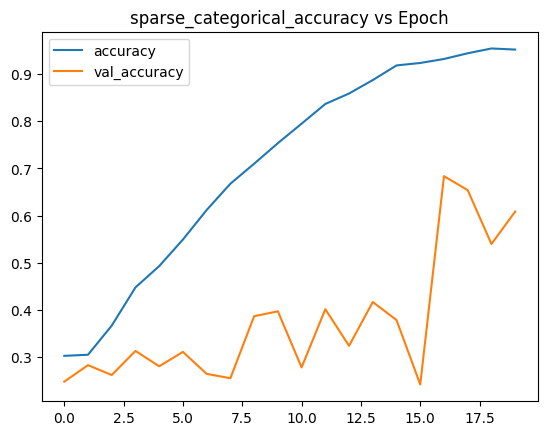

In [ ]:
# Gráfica de accuracy
df4.plot(y=["accuracy", "val_accuracy"], title="sparse_categorical_accuracy vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

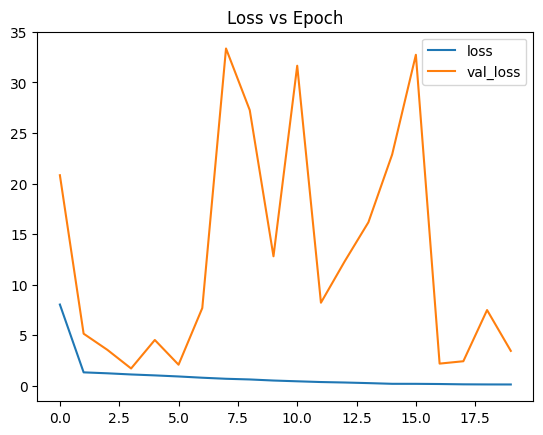

In [ ]:
# Gráfica de pérdida
df4.plot(y=["loss", "val_loss"], title="Loss vs Epoch")

**Notas:**
- Accuracy sube muy bien
- Validation accuracy pareciera tener una tendencia positiva pero no es nada constante

**Modelo 5 (cuenta alterna)**
- Se utilizan los datos cargados desde drive y utilizando la división 80-10-10 para el conjunto de entrenamiento, validación y prueba respectivamente.

**Modelo 6 (cuenta alterna)**
- Se utilizan los datos cargados desde Kaggle y se mantiene el Autotune y Batch Normalization.
- Se agregan Dropouts con tasa de 0.8 para seguir controlando el overfitting
- Se mantuvo el validation accuracy entre 0.25 y 0.25



## Modelo 7

**Adiciones / Modificaciones:**

- Se repite el modelo 6 pero se agregan regularizadores en la últimas capas densas

In [ ]:
from tensorflow.keras import regularizers

# Se establece el tamaño inicial que necesitamos y la cantidad de categorías a clasificar
input_shape = (240, 320, 3)
num_classes = 4

# Construcción de un modelo secuencial
model7 = Sequential()
model7.add(Rescaling(scale=1./255, input_shape=input_shape))
#model2.add(tf.keras.layers.experimental.preprocessing.Resizing(100, 100, interpolation='bilinear'))

# Capas convolucionales iniciales
model7.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2, 2)))

model7.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2, 2)))

model7.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2, 2)))

# Capa para "aplanar" las imágenes antes de las capas densas
model7.add(Flatten())

# Fully connected layers
model7.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model7.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model7.add(Dropout(0.8))

model7.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model7.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Como se esperaba, dada la agregada complejidad del modelo, ahora se tiene una mayor cantidad de parámetros a entrenar: 139,964,292

In [ ]:
# Resumen del modelo
model7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 320, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 238, 318, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 238, 318, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 119, 159, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 157, 128)     73856     
                                                                 
 batch_normalization_1 (Bat  (None, 117, 157, 128)     5

In [ ]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# Fit
#lr_scheduler = LearningRateScheduler(lr_schedule)
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history7 = model7.fit(train_dataset, validation_data=val_dataset, batch_size=128, epochs=20)

Epoch 1/20
78/78 [==============================] - 119s 1s/step - loss: 40.0558 - accuracy: 0.2532 - val_loss: 23.7206 - val_accuracy: 0.2734
Epoch 2/20
78/78 [==============================] - 86s 1s/step - loss: 13.0565 - accuracy: 0.2469 - val_loss: 7.8227 - val_accuracy: 0.2465
Epoch 3/20
78/78 [==============================] - 88s 1s/step - loss: 5.4217 - accuracy: 0.2441 - val_loss: 4.8150 - val_accuracy: 0.2698
Epoch 4/20
78/78 [==============================] - 88s 1s/step - loss: 3.7253 - accuracy: 0.2401 - val_loss: 3.5340 - val_accuracy: 0.2602
Epoch 5/20
78/78 [==============================] - 89s 1s/step - loss: 3.2256 - accuracy: 0.2484 - val_loss: 3.0265 - val_accuracy: 0.2529
Epoch 6/20
78/78 [==============================] - 93s 1s/step - loss: 2.8961 - accuracy: 0.2476 - val_loss: 2.8219 - val_accuracy: 0.2473
Epoch 7/20
78/78 [==============================] - 88s 1s/step - loss: 2.9845 - accuracy: 0.2503 - val_loss: 3.4923 - val_accuracy: 0.2823
Epoch 8/20
78/78

**Notas:** El accuracy y validation accuracy se quedan alrededor de 0.25

**Modelo 8 (cuenta alterna)**
- Con la idea de simplificar el modelo, se le quita la última capa de convolución al modelo 6
- Los resultados son muy malos, se tiene que mantener esa capa, incluso pensar el hacer el modelo más complejo

**Modelo 9 (cuenta alterna)**
- Se repite modelo 6 pero sin especificar el input shape de las imágenes para evitar la pérdida de información o la deformación de la imagen.
- Nuevamente se carga con la imágenes separadas en 80-10-10


## Modelo 10

**Adiciones / Modificaciones:**

- Se repite la arquitectura del modelo 4 agregándole regularizador

In [ ]:
from tensorflow.keras import regularizers

# Se establece el tamaño inicial que necesitamos y la cantidad de categorías a clasificar
input_shape = (240, 320, 3)
num_classes = 4

# Construcción de un modelo secuencial
model10 = Sequential()
model10.add(Rescaling(scale=1./255, input_shape=input_shape))
#model2.add(tf.keras.layers.experimental.preprocessing.Resizing(100, 100, interpolation='bilinear'))

# Capas convolucionales iniciales
model10.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model10.add(BatchNormalization())
model10.add(MaxPooling2D(pool_size=(2, 2)))

model10.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model10.add(BatchNormalization())
model10.add(MaxPooling2D(pool_size=(2, 2)))

model10.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model10.add(BatchNormalization())
model10.add(MaxPooling2D(pool_size=(2, 2)))

# Capa para "aplanar" las imágenes antes de las capas densas
model10.add(Flatten())

# Fully connected layers
model10.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model10.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model10.add(Dropout(0.5))

model10.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model10.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Como se esperaba, dada la agregada complejidad del modelo, ahora se tiene una mayor cantidad de parámetros a entrenar: 139,964,292

In [ ]:
# Resumen del modelo
model10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 320, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 238, 318, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 238, 318, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 119, 159, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 157, 128)     73856     
                                                                 
 batch_normalization_1 (Bat  (None, 117, 157, 128)     5

In [ ]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# Fit
#lr_scheduler = LearningRateScheduler(lr_schedule)
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history10 = model10.fit(train_dataset, validation_data=val_dataset, batch_size=128, epochs=20)

Epoch 1/20
78/78 [==============================] - 112s 1s/step - loss: 37.7540 - accuracy: 0.2851 - val_loss: 19.8019 - val_accuracy: 0.2445
Epoch 2/20
78/78 [==============================] - 84s 1s/step - loss: 9.8593 - accuracy: 0.2921 - val_loss: 5.7272 - val_accuracy: 0.2682
Epoch 3/20
78/78 [==============================] - 84s 1s/step - loss: 4.5328 - accuracy: 0.3585 - val_loss: 3.9820 - val_accuracy: 0.2529
Epoch 4/20
78/78 [==============================] - 84s 1s/step - loss: 3.6100 - accuracy: 0.4404 - val_loss: 3.8021 - val_accuracy: 0.2589
Epoch 5/20
78/78 [==============================] - 85s 1s/step - loss: 3.2789 - accuracy: 0.4931 - val_loss: 4.0917 - val_accuracy: 0.2722
Epoch 6/20
78/78 [==============================] - 85s 1s/step - loss: 3.1546 - accuracy: 0.5545 - val_loss: 8.2534 - val_accuracy: 0.2545
Epoch 7/20
78/78 [==============================] - 90s 1s/step - loss: 3.0605 - accuracy: 0.6008 - val_loss: 4.5852 - val_accuracy: 0.3635
Epoch 8/20
78/78 

In [ ]:
# Convertir resultados a df
df10 = pd.DataFrame(history10.history)
df10

,loss,accuracy,val_loss,val_accuracy
0,37.753956,0.285126,19.801897,0.244471
1,9.859320,0.292056,5.727204,0.268195
2,4.532758,0.358542,3.981985,0.252915
3,3.610024,0.440394,3.802088,0.258947
4,3.278945,0.493120,4.091687,0.272216
5,3.154554,0.554484,8.253447,0.254524
6,3.060548,0.600783,4.585246,0.363490
7,2.807348,0.651501,12.564885,0.271009
8,2.987342,0.701617,5.944176,0.318054
9,2.858144,0.777443,10.611655,0.268597


<Axes: title={'center': 'sparse_categorical_accuracy vs Epoch'}>

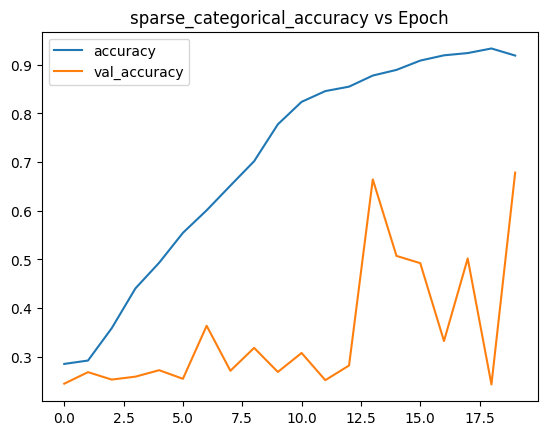

In [ ]:
# Gráfica de accuracy
df10.plot(y=["accuracy", "val_accuracy"], title="sparse_categorical_accuracy vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

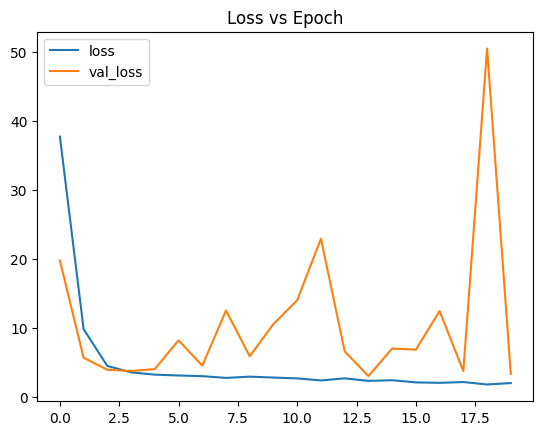

In [ ]:
# Gráfica de pérdida
df10.plot(y=["loss", "val_loss"], title="Loss vs Epoch")

**Notas:**
- Resultados siguen brincando de forma inconsistentemente
- Se deben introducir más técnicas de regularización como subirle a la tasa del dropout o al de los regularizadores


**Modelo 13 (cuenta alterna)**
- Se intentan mejorar los resultados del modelo 12 con un dropout de 0.5 pero esto impide que el validation accuracy suba como en el modelo 12.

**Modelo 14 (cuenta alterna)**
- Se agrega otra capa densa con su dropout
- Resultados no superan a los del modelo 12

# VGG19

Se intenta utilizar una técnica de transfer learning, en este caso VGG19

In [15]:
# Se crean los batches de entrenamiento,validación y test con las cuatro clases de forma aleatoria

%cd "/content/kaggledb/dataset2-master/dataset2-master/images/"

train_dataset = image_dataset_from_directory(
    pathlib.Path("TRAIN"),
    batch_size=128,
    image_size=(224, 224),
    shuffle=True,
    crop_to_aspect_ratio= True)
validation_dataset = image_dataset_from_directory(
    pathlib.Path("TEST"),
    batch_size=128,
    image_size=(224, 224),
    shuffle=True,
    crop_to_aspect_ratio= True)
test_dataset = image_dataset_from_directory(
    pathlib.Path("TEST_SIMPLE"),
    batch_size=128,
    image_size=(224, 224),
    shuffle=True,
    crop_to_aspect_ratio= True)

/content/kaggledb/dataset2-master/dataset2-master/images
Found 9957 files belonging to 4 classes.
Found 2487 files belonging to 4 classes.
Found 71 files belonging to 4 classes.


In [16]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [17]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

num_classes = 4

# VGG 19 con Keras. Pesos entrenados con imagenet. No incluimos pesos de las FCL al final (estas las entrenaré yo)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Input shape que necesita la VGG19

# Se congelan los pesos del resto de la red
for layer in base_model.layers:
    layer.trainable = False


x = Flatten()(base_model.output)
# FCL entrenadas con mis imágenes
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)


model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [18]:
history_vgg = model.fit(train_dataset, validation_data=val_dataset, batch_size=128, epochs=20)

Epoch 1/20
78/78 [==============================] - 100s 1s/step - loss: 13.9459 - accuracy: 0.5599 - val_loss: 1.7976 - val_accuracy: 0.5018
Epoch 2/20
78/78 [==============================] - 66s 832ms/step - loss: 0.2314 - accuracy: 0.9176 - val_loss: 2.0200 - val_accuracy: 0.4753
Epoch 3/20
78/78 [==============================] - 72s 912ms/step - loss: 0.0445 - accuracy: 0.9894 - val_loss: 2.2295 - val_accuracy: 0.4540
Epoch 4/20
78/78 [==============================] - 66s 828ms/step - loss: 0.0136 - accuracy: 0.9990 - val_loss: 2.1395 - val_accuracy: 0.4926
Epoch 5/20
78/78 [==============================] - 65s 825ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 2.1434 - val_accuracy: 0.4922
Epoch 6/20
78/78 [==============================] - 72s 914ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 2.1508 - val_accuracy: 0.4978
Epoch 7/20
78/78 [==============================] - 66s 831ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 2.2299 - val_accuracy: 0.4950


In [19]:
# Convertir resultados a df
df_vgg = pd.DataFrame(history_vgg.history)
df_vgg

,loss,accuracy,val_loss,val_accuracy
0,13.945919,0.559908,1.797648,0.501809
1,0.231370,0.917646,2.020010,0.475271
2,0.044514,0.989354,2.229455,0.453961
3,0.013574,0.998996,2.139542,0.492561
4,0.005918,1.000000,2.143373,0.492159
5,0.004062,1.000000,2.150840,0.497788
6,0.003052,1.000000,2.229856,0.494974
7,0.002431,1.000000,2.245129,0.495778
8,0.001985,1.000000,2.288643,0.494170
9,0.001661,1.000000,2.315127,0.496984


<Axes: title={'center': 'sparse_categorical_accuracy vs Epoch'}>

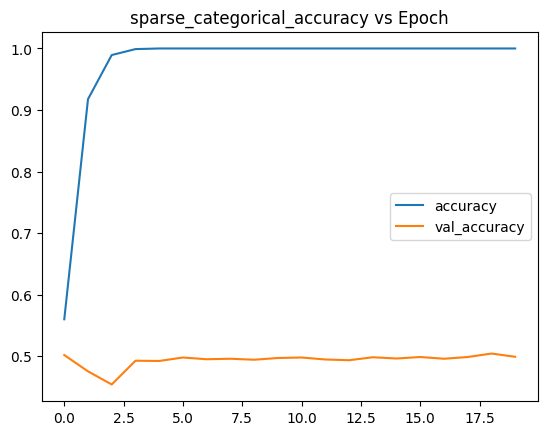

In [20]:
# Gráfica de accuracy
df_vgg.plot(y=["accuracy", "val_accuracy"], title="sparse_categorical_accuracy vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

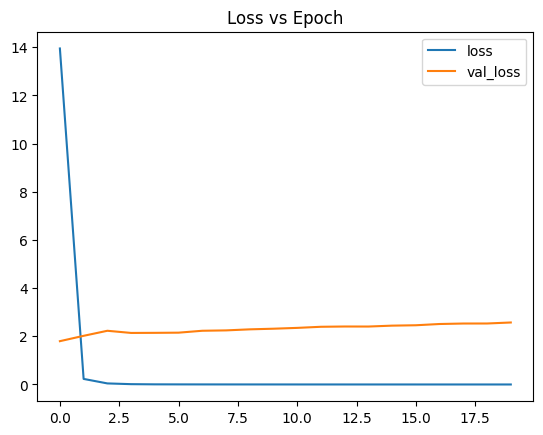

In [21]:
# Gráfica de pérdida
df_vgg.plot(y=["loss", "val_loss"], title="Loss vs Epoch")

**Notas:** El validation accuracy se mantiene en 0.5

# Modelo 12 (el mejor resultado)

**Características:**

- Basada en la arquitectura 4
- 4 capas de convolución (una adicional a la arquitectura 4)
- Cada capa seguida de un Batch Normalization y Max Pooling
- Tres capas densas al final con su Dropout de tasa 0.3
- Los datos de entrenamiento utilizados son cargados desde Drive con la división 80-10-10
- Al cargar los datos y al generar el modelo, no se especifica el tamaño de la imagen para evitar distorsionarla

In [ ]:
# Se establece el tamaño inicial que necesitamos y la cantidad de categorías a clasificar
#input_shape = (240, 320, 3)
num_classes = 4

# Construcción de un modelo secuencial
model12 = Sequential()
model12.add(Rescaling(scale=1./255))
#model2.add(tf.keras.layers.experimental.preprocessing.Resizing(100, 100, interpolation='bilinear'))

# Capas convolucionales iniciales
model12.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model12.add(BatchNormalization())
model12.add(MaxPooling2D(pool_size=(2, 2)))

model12.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model12.add(BatchNormalization())
model12.add(MaxPooling2D(pool_size=(2, 2)))

model12.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model12.add(BatchNormalization())
model12.add(MaxPooling2D(pool_size=(2, 2)))

model12.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model12.add(BatchNormalization())
model12.add(MaxPooling2D(pool_size=(2, 2)))

# Capa para "aplanar" las imágenes antes de las capas densas
model12.add(Flatten())

# Fully connected layers
model12.add(Dense(512, activation='relu'))
model12.add(Dropout(0.3))

model12.add(Dense(256, activation='relu'))
model12.add(Dropout(0.3))

model12.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model12.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Como se esperaba, dada la agregada complejidad del modelo, ahora se tiene una mayor cantidad de parámetros a entrenar: 139,964,292

In [ ]:
# Resumen del modelo
model12.summary()

In [ ]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# Fit
#lr_scheduler = LearningRateScheduler(lr_schedule)
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history12 = model12.fit(train_dataset, validation_data=val_dataset, batch_size=128, epochs=20)

Epoch 1/20
78/78 [==============================] - 113s 1s/step - loss: 6.4307 - accuracy: 0.3798 - val_loss: 1.4034 - val_accuracy: 0.2903
Epoch 2/20
78/78 [==============================] - 77s 969ms/step - loss: 1.2815 - accuracy: 0.4551 - val_loss: 2.2174 - val_accuracy: 0.2678
Epoch 3/20
78/78 [==============================] - 72s 908ms/step - loss: 1.0028 - accuracy: 0.5829 - val_loss: 7.7601 - val_accuracy: 0.2730
Epoch 4/20
78/78 [==============================] - 72s 911ms/step - loss: 0.8347 - accuracy: 0.6668 - val_loss: 19.3363 - val_accuracy: 0.2573
Epoch 5/20
78/78 [==============================] - 74s 928ms/step - loss: 0.7385 - accuracy: 0.7101 - val_loss: 13.3358 - val_accuracy: 0.2525
Epoch 6/20
78/78 [==============================] - 72s 905ms/step - loss: 0.6276 - accuracy: 0.7539 - val_loss: 4.8504 - val_accuracy: 0.3603
Epoch 7/20
78/78 [==============================] - 76s 964ms/step - loss: 0.5907 - accuracy: 0.7782 - val_loss: 5.2734 - val_accuracy: 0.3116

In [ ]:
# Convertir resultados a df
df12 = pd.DataFrame(history12.history)
df12

,loss,accuracy,val_loss,val_accuracy
0,6.430662,0.379833,1.403405,0.290310
1,1.281452,0.455057,2.217397,0.267793
2,1.002807,0.582906,7.760120,0.273020
3,0.834661,0.666767,19.336296,0.257338
4,0.738544,0.710053,13.335779,0.252513
5,0.627583,0.753942,4.850436,0.360273
6,0.590738,0.778246,5.273426,0.311620
7,0.502977,0.816511,12.321777,0.342984
8,0.403413,0.855880,4.531384,0.540008
9,0.339192,0.882394,9.255937,0.410937


<Axes: title={'center': 'sparse_categorical_accuracy vs Epoch'}>

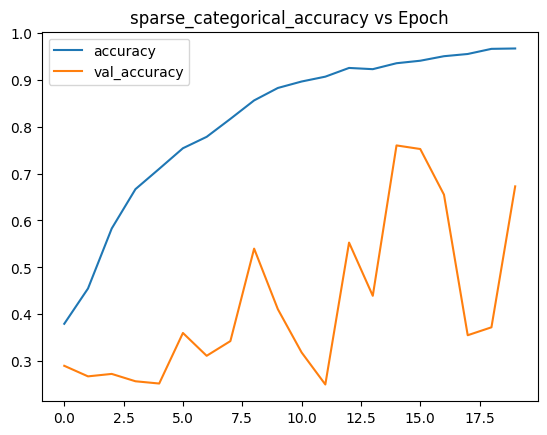

In [ ]:
# Gráfica de accuracy
df12.plot(y=["accuracy", "val_accuracy"], title="sparse_categorical_accuracy vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

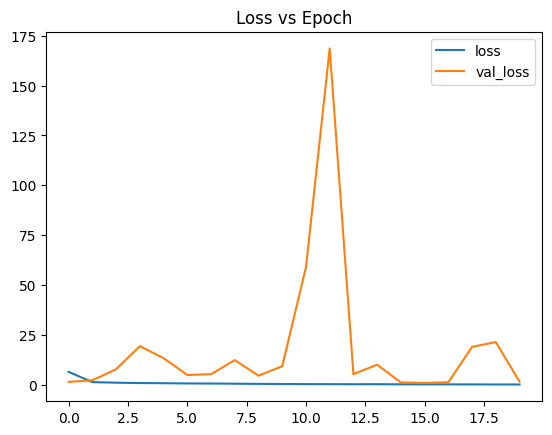

In [ ]:
# Gráfica de pérdida
df12.plot(y=["loss", "val_loss"], title="Loss vs Epoch")

**Notas:** Se aprecia una precisión con una tendencia positiva. Se alcanzan los valores más altos de precisión que en cualquier otro modelo superando el 0.7. La precisión de los datos de validación siguen siendo muy inconstantes sin embargo se observa una gran mejora respecto a los primeros entregables y los modelos procedentes a estos. Como posibles mejoras, se podría seguir experimentando con la arquitectura de la red y volverla aún más compleja ya que a lo largo del proceso de experimentación, esto fue lo que demostró generar los mejores resultados.

# Modelo 12 (COPIA)

**Características:**

- Basada en la arquitectura 4
- 4 capas de convolución (una adicional a la arquitectura 4)
- Cada capa seguida de un Batch Normalization y Max Pooling
- Tres capas densas al final con su Dropout de tasa 0.3
- Los datos de entrenamiento utilizados son cargados desde Drive con la división 80-10-10
- Al cargar los datos y al generar el modelo, no se especifica el tamaño de la imagen para evitar distorsionarla

In [16]:
# Se establece el tamaño inicial que necesitamos y la cantidad de categorías a clasificar
#input_shape = (240, 320, 3)
num_classes = 4

# Construcción de un modelo secuencial
model12 = Sequential()
model12.add(Rescaling(scale=1./255))
#model2.add(tf.keras.layers.experimental.preprocessing.Resizing(100, 100, interpolation='bilinear'))

# Capas convolucionales iniciales
model12.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model12.add(BatchNormalization())
model12.add(MaxPooling2D(pool_size=(2, 2)))

model12.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model12.add(BatchNormalization())
model12.add(MaxPooling2D(pool_size=(2, 2)))

model12.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model12.add(BatchNormalization())
model12.add(MaxPooling2D(pool_size=(2, 2)))

model12.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model12.add(BatchNormalization())
model12.add(MaxPooling2D(pool_size=(2, 2)))

# Capa para "aplanar" las imágenes antes de las capas densas
model12.add(Flatten())

# Fully connected layers
model12.add(Dense(512, activation='relu'))
model12.add(Dropout(0.3))

model12.add(Dense(256, activation='relu'))
model12.add(Dropout(0.3))

model12.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model12.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Como se esperaba, dada la agregada complejidad del modelo, ahora se tiene una mayor cantidad de parámetros a entrenar: 139,964,292

In [ ]:
# Resumen del modelo
model12.summary()

In [17]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [18]:
# Fit
#lr_scheduler = LearningRateScheduler(lr_schedule)
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history12 = model12.fit(train_dataset, validation_data=val_dataset, batch_size=128, epochs=20)

Epoch 1/20
78/78 [==============================] - 103s 1s/step - loss: 6.0872 - accuracy: 0.3621 - val_loss: 1.4806 - val_accuracy: 0.2392
Epoch 2/20
78/78 [==============================] - 72s 906ms/step - loss: 1.2557 - accuracy: 0.4390 - val_loss: 1.4503 - val_accuracy: 0.2533
Epoch 3/20
78/78 [==============================] - 69s 871ms/step - loss: 1.0718 - accuracy: 0.5260 - val_loss: 2.6925 - val_accuracy: 0.3659
Epoch 4/20
78/78 [==============================] - 69s 874ms/step - loss: 0.9421 - accuracy: 0.5932 - val_loss: 2.0690 - val_accuracy: 0.3542
Epoch 5/20
78/78 [==============================] - 69s 868ms/step - loss: 0.8255 - accuracy: 0.6657 - val_loss: 1.4818 - val_accuracy: 0.3961
Epoch 6/20
78/78 [==============================] - 69s 872ms/step - loss: 0.7342 - accuracy: 0.7135 - val_loss: 3.3732 - val_accuracy: 0.2630
Epoch 7/20
78/78 [==============================] - 69s 874ms/step - loss: 0.6109 - accuracy: 0.7557 - val_loss: 2.4432 - val_accuracy: 0.4387
E

In [19]:
# Convertir resultados a df
df12 = pd.DataFrame(history12.history)
df12

,loss,accuracy,val_loss,val_accuracy
0,6.087163,0.362057,1.480594,0.239244
1,1.255659,0.438988,1.450277,0.253317
2,1.071776,0.525962,2.692521,0.365903
3,0.942077,0.593151,2.068958,0.354242
4,0.825467,0.665662,1.481791,0.396060
5,0.734213,0.713468,3.373227,0.262967
6,0.610898,0.755750,2.443233,0.438681
7,0.528556,0.803053,1.734741,0.605147
8,0.451749,0.829668,7.175196,0.351829
9,0.360127,0.867430,3.731945,0.395657


<Axes: title={'center': 'sparse_categorical_accuracy vs Epoch'}>

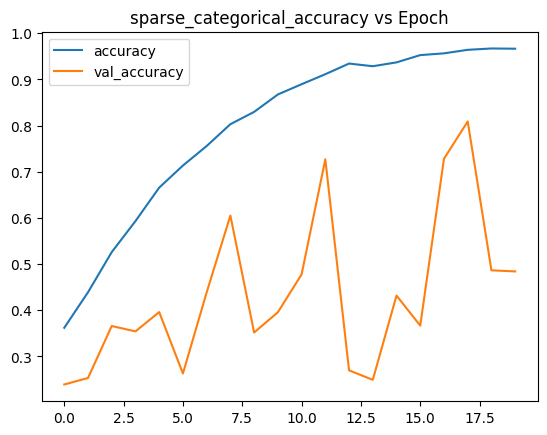

In [20]:
# Gráfica de accuracy
df12.plot(y=["accuracy", "val_accuracy"], title="sparse_categorical_accuracy vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

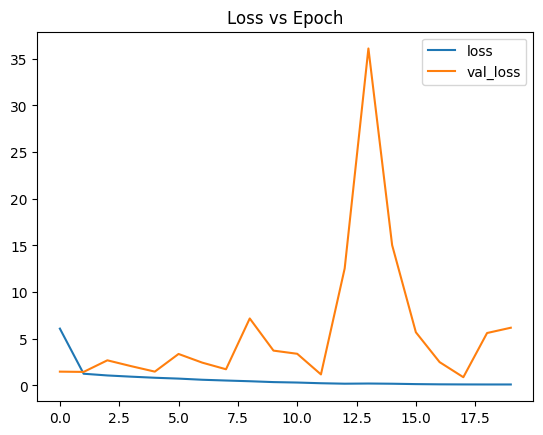

In [21]:
# Gráfica de pérdida
df12.plot(y=["loss", "val_loss"], title="Loss vs Epoch")

**Notas:** Se aprecia una precisión con una tendencia positiva. Se alcanzan los valores más altos de precisión que en cualquier otro modelo superando el 0.7. La precisión de los datos de validación siguen siendo muy inconstantes sin embargo se observa una gran mejora respecto a los primeros entregables y los modelos procedentes a estos. Como posibles mejoras, se podría seguir experimentando con la arquitectura de la red y volverla aún más compleja ya que a lo largo del proceso de experimentación, esto fue lo que demostró generar los mejores resultados.

# Predicciones

Image Label:  0


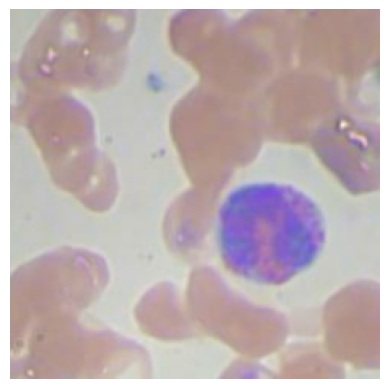

In [49]:
# Assuming test_dataset is a tf.data.Dataset object
for images, labels in test_dataset:
    # Select a random index to display an image
    random_index = np.random.randint(0, len(images))
    image = images[random_index]  # Extract the random image
    label = int(labels[random_index])
    print("Image Label: ", label)
    # Display the image using Matplotlib
    plt.imshow(image.numpy().astype("uint8"))
    plt.axis('off')  # Hide axes
    plt.show()
    break  # Stop after displaying one image

In [50]:
# Se normaliza la imagen
normalized_image = image / 255.0

predictions = model12.predict(np.expand_dims(normalized_image, axis=0))

predicted_label = np.argmax(predictions) # Para sacar la probabilidad más alta del softmax

# Print the predicted label
print(f'Clase predicha: {predicted_label}')

if predicted_label == label:
    print('Predicción correcta')
else:
    print('Predicción incorrecta')

1/1 [==============================] - 0s 30ms/step
Clase predicha: 2
Predicción incorrecta
